### Import Packages

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np

### Global attributes

In [2]:
mixed_dir = "mixed_data/"
clean_dir = "clean_data/"

### Preprocess Data

In [3]:
# MelSpectrogram參數
n_mels = 128
n_fft = 4096
hop_length = n_fft // 2
win_length = None 
sample_rate = 22050
f_max = sample_rate // 2

In [ ]:
def load_dataset(mixed_dir, clean_dir):
    min_time_length = float('inf')
    mixed_mel_spectrograms = []
    clean_mel_spectrograms = []

    for filename in sorted(os.listdir(mixed_dir)):       
        mixed_waveform, sr = librosa.load(''.join([mixed_dir, filename]), sr=None, duration=15)
        clean_waveform, sr = librosa.load(''.join([clean_dir, filename]), sr=None, duration=15)

        if(filename == "1034-121119-0049.wav"):
            print(clean_waveform)
            librosa.display.waveshow(clean_waveform, sr=sample_rate)
            #librosa.display.waveshow(mixed_waveform, sr=sample_rate)
        mixed_mel_spectrogram = librosa.feature.melspectrogram(y=mixed_waveform, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
        clean_mel_spectrogram = librosa.feature.melspectrogram(y=clean_waveform, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
            
        # 找最大的頻譜圖長度
        min_time_length = min(min_time_length, mixed_mel_spectrogram.shape[-1], clean_mel_spectrogram.shape[-1])
        min_time_length = (min_time_length // 8) * 8

        mixed_mel_spectrograms.append(mixed_mel_spectrogram)
        clean_mel_spectrograms.append(clean_mel_spectrogram)

    # 填充所有頻譜圖到相同的長度
    mixed_mel_spectrograms = [m[:, :min_time_length] for m in mixed_mel_spectrograms]
    clean_mel_spectrograms = [c[:, :min_time_length] for c in clean_mel_spectrograms]
    return mixed_mel_spectrograms, clean_mel_spectrograms

1034-121119-0049.wav
[0.0027771  0.00137329 0.00091553 ... 0.00631714 0.00656128 0.0057373 ]
1040-133433-0080.wav
1081-125237-0053.wav
1081-125237-0085.wav
1183-133256-0005.wav
1246-124550-0005.wav
125-121124-0076.wav
1334-135589-0002.wav
1355-39947-0035.wav
1578-140049-0004.wav
1624-142933-0019.wav
1898-145702-0006.wav
19-198-0034.wav
196-122150-0032.wav
198-126831-0000.wav
200-126784-0026.wav
2002-139469-0093.wav
2007-132570-0059.wav
2092-145706-0067.wav
2136-5143-0025.wav
2136-5143-0028.wav
2159-179156-0013.wav
2182-150130-0028.wav
2182-181173-0033.wav
226-131532-0003.wav
226-131533-0002.wav
2416-152139-0041.wav
2514-149482-0005.wav
2514-149482-0033.wav
2518-154826-0030.wav
2691-156755-0035.wav
2893-139322-0043.wav
2952-407-0002.wav
2952-410-0047.wav
298-126790-0038.wav
298-126791-0067.wav
2989-138035-0043.wav
302-123523-0025.wav
307-127535-0005.wav
3112-9555-0084.wav
3242-67153-0004.wav
3259-158083-0089.wav
332-128985-0073.wav
3374-298025-0000.wav
3374-298025-0010.wav
3374-298025-0

KeyboardInterrupt: 

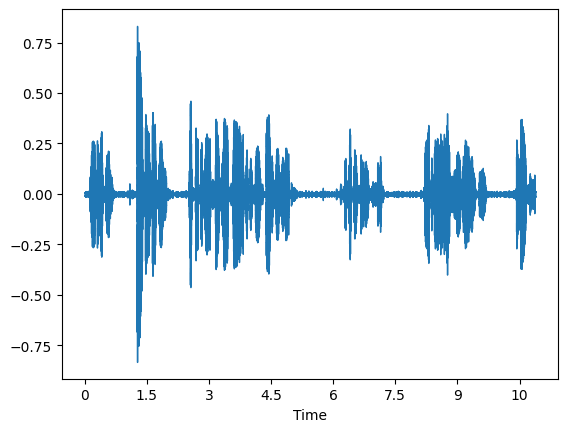

In [5]:
mixed_mel_spectrograms_list, clean_mel_spectrograms_list = load_dataset(mixed_dir, clean_dir)

# reshape the shape to fit pytorch
# mixed_mel_spectrograms = torch.FloatTensor(mixed_mel_spectrograms_list)
# clean_mel_spectrograms = torch.FloatTensor(clean_mel_spectrograms_list)
# print(mixed_mel_spectrograms.dtype)
# print(mixed_mel_spectrograms.shape)

# mixed_mel_spectrograms = [mel.unsqueeze(0) for mel in mixed_mel_spectrograms]
# clean_mel_spectrograms = [mel.unsqueeze(0) for mel in clean_mel_spectrograms]

# change to log scale
mixed_mel_spectrograms_db = librosa.power_to_db(mixed_mel_spectrograms_list, ref=np.max)
clean_mel_spectrograms_db = librosa.power_to_db(clean_mel_spectrograms_list, ref=np.max)

# change to tensor
mixed_mel_spectrograms = [torch.FloatTensor(mel).unsqueeze(0) for mel in mixed_mel_spectrograms_list]
clean_mel_spectrograms = [torch.FloatTensor(mel).unsqueeze(0) for mel in clean_mel_spectrograms_list]


# 打印第一個 Mel 頻譜圖

# print(mixed_mel_spectrograms[0].dtype)
# print(mixed_mel_spectrograms[0].shape)
# print(mixed_mel_spectrograms[0])
# print(clean_mel_spectrograms[0].dtype)
# print(clean_mel_spectrograms[0].shape)
# print(clean_mel_spectrograms[0])

fig, ax = plt.subplots()
img = librosa.display.specshow(mixed_mel_spectrograms_db[0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

### Training

In [ ]:
class DenoiseAutoencoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoencoder, self).__init__()
        # 編碼器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        # 解碼器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
# Model參數
num_epochs = 25
batch_size = 32
learning_rate = 0.001

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, mixed_data, clean_data):
        self.mixed = mixed_data
        self.clean = clean_data
    
    def __len__(self):
        return len(self.mixed)
    
    def __getitem__(self, idx):
        return self.mixed[idx], self.clean[idx]

dataset = AudioDataset(mixed_mel_spectrograms, clean_mel_spectrograms)
dataloader = DataLoader(dataset, batch_size=batch_size)


In [ ]:
# 初始化模型、損失函數和優化器
model = DenoiseAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 訓練過程
for epoch in range(num_epochs):
    model.train()
    for (mixed, clean) in dataloader:
        
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(mixed)
        # print(mixed[0])
        # print(clean)
        loss = criterion(outputs, clean)
            
        # 反向傳播和優化
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

### Prediction

In [ ]:
# print(mixed_mel_spectrograms[0].shape)
# print(mixed_mel_spectrograms[0].dtype)

# 应用模型
model.eval()  # 设置模型为评估模式
# test_waveform, sr = librosa.load("mixed_data/8975-270782-0032.wav")
# test_mel_spectrogram = librosa.feature.melspectrogram(y=test_waveform, sr=sample_rate)
waveform, sample_rate = librosa.load("clean_data/1034-121119-0049.wav")
# librosa.display.waveshow(waveform, sr=sample_rate)
# librosa.display.waveshow(mixed_mel_spectrograms_db[0], sr=sample_rate)

denoised_output = model(mixed_mel_spectrograms[0])  # 添加批次和通道维度
print(waveform)

print("去噪后的输出形状:", denoised_output.shape)
print(denoised_output)
# tensor to list
# denoised_output = (denoised_output.squeeze(0)).tolist()
# print(denoised_output.shape)
# print(denoised_output.dtype)
# denoised_output = denoised_output.detach().cpu().numpy()
denoised_output = denoised_output.squeeze().detach().numpy()
print(denoised_output)
# denoised_output = librosa.db_to_power(denoised_output)
# print(denoised_output.shape)
# print(denoised_output.dtype)
# denoised_output = denoised_output.squeeze(0)
# print(denoised_output)
# print(denoised_output.shape)
# print(denoised_output.dtype)

audio_signal = librosa.feature.inverse.mel_to_audio(denoised_output, sr=sample_rate)
# print(audio_signal.shape)
# print(audio_signal.dtype)
# print(audio_signal)
librosa.display.waveshow(audio_signal, sr=sample_rate)

soundfile.write('test.wav', audio_signal, sample_rate)
